In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.1 MB/s 
     |████████████████████████████████| 9.8 MB 53.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 2.1 MB/s 


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

Dataset

In [ ]:
raw_data = yfinance.download(
                    tickers=["PFIZER.NS",'^NSEI'],
                    start="2014-12-31",
                    group_by="ticker",
                    auto_adjust=True,
                    interval="1d",
                    treads=True
                    )

[*********************100%***********************]  2 of 2 completed



Data **Preprocessing** 

In [ ]:
df1 = raw_data.copy()
df1["PFIZER"] = df1["PFIZER.NS"].Close
df1["nse"] = df1["^NSEI"].Close

In [ ]:
del df1["PFIZER.NS"], df1["^NSEI"]
df1 = df1.asfreq("b")
df1 = df1.fillna(method="bfill")
df1["PFIZER_ret"] = df1.PFIZER.pct_change(1).mul(100)
df1["nse_ret"] = df1.nse.pct_change(1).mul(100)
df1.head()

,PFIZER,nse,PFIZER_ret,nse_ret
,,,,
Date,,,,
2014-12-31,1934.453491,8282.700195,NaN,NaN
2015-01-01,1968.031982,8395.450195,1.735813,1.361271
2015-01-02,1993.350342,8395.450195,1.286481,0.000000
2015-01-05,2012.428955,8378.400391,0.957113,-0.203084
2015-01-06,1990.387573,8127.350098,-1.095263,-2.996399


In [ ]:
train_idx = int(len(df1)*0.8)
#val_idx = train_idx+int(len(df)*0.15)

df_train, df_test = df1.iloc[:train_idx], df1.iloc[train_idx:]

In [ ]:
df_test.head()

,PFIZER,nse,PFIZER_ret,nse_ret
,,,,
Date,,,,
2021-02-26,4510.429199,14529.150391,-0.172166,-3.763569
2021-03-01,4589.455566,14761.549805,1.752081,1.599539
2021-03-02,4611.454102,14919.099609,0.479328,1.067299
2021-03-03,4602.882324,15245.599609,-0.185880,2.188470
2021-03-04,4568.745117,15080.750000,-0.741648,-1.081293


In [ ]:
df_test.tail()

,PFIZER,nse,PFIZER_ret,nse_ret
,,,,
Date,,,,
2022-09-06,4311.649902,17655.599609,0.799535,-0.057745
2022-09-07,4340.799805,17624.400391,0.676073,-0.176710
2022-09-08,4320.700195,17798.750000,-0.463039,0.989251
2022-09-09,4324.000000,17833.349609,0.076372,0.194393
2022-09-12,4312.549805,17964.199219,-0.264806,0.733735


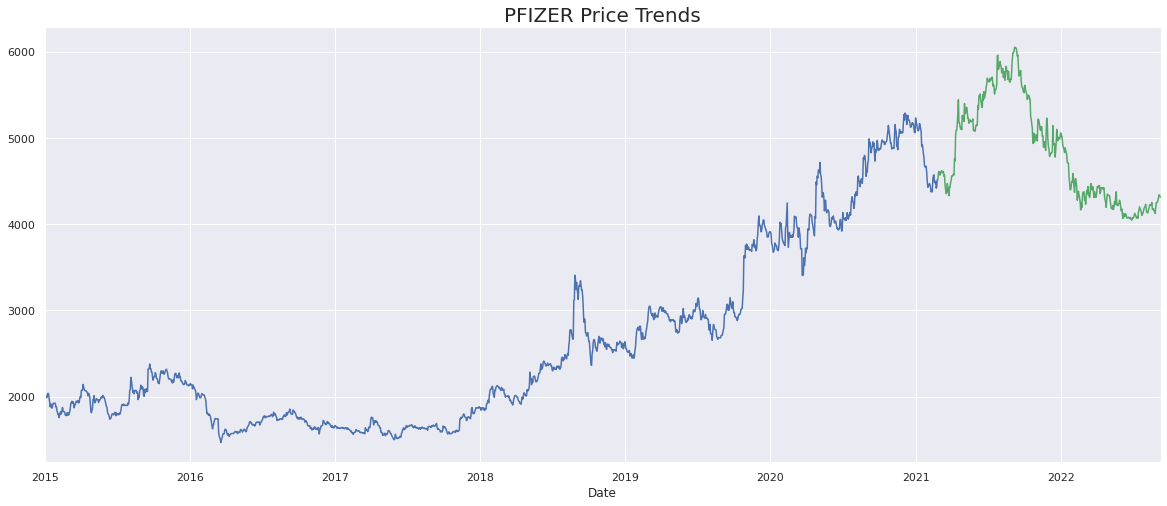

In [ ]:
df_train.PFIZER.plot(figsize = (20,8), color="b")
df_test.PFIZER.plot(color="g")
plt.title("PFIZER Price Trends", size=20)
plt.show()

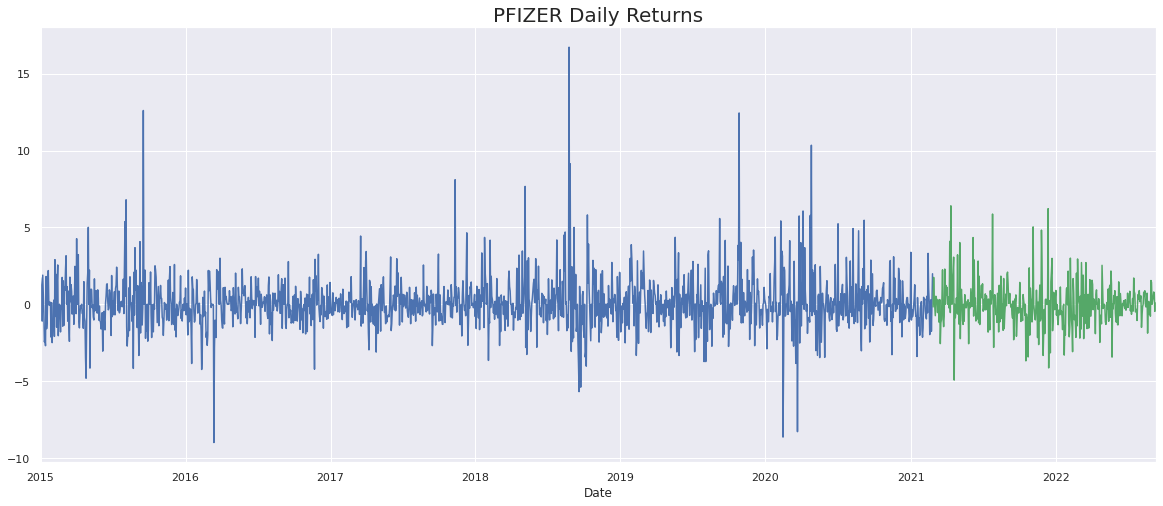

In [ ]:
df_train.PFIZER_ret.plot(figsize = (20,8), color="b")
df_test.PFIZER_ret.plot(color="g")
plt.title("PFIZER Daily Returns", size=20)
plt.show()

In [ ]:
sts.adfuller(df1.PFIZER)

(-0.9083143033972095,
 0.7852220684161412,
 26,
 1982,
 {'1%': -3.4336536273681078,
  '5%': -2.862999357426174,
  '10%': -2.567546900734257},
 21403.124702911173)

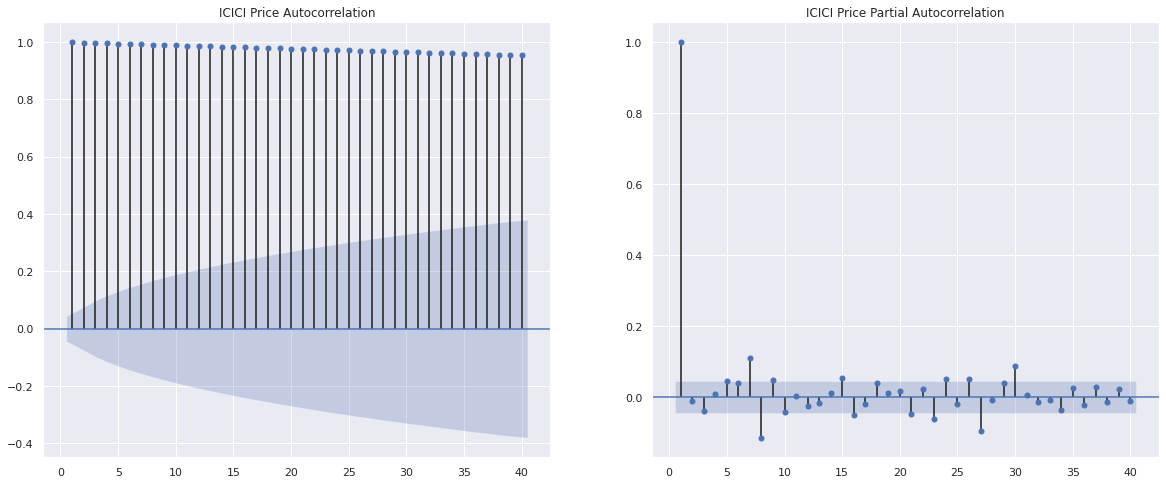

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sgt.plot_acf(df1.PFIZER, lags=40, zero=False, ax=ax1, title='ICICI Price Autocorrelation')
sgt.plot_pacf(df1.PFIZER,lags=40, zero=False, ax=ax2, title='ICICI Price Partial Autocorrelation')
plt.show()

In [ ]:
sts.adfuller(df1.PFIZER_ret[1:])

(-15.175672577780144,
 6.299972298098607e-28,
 8,
 1999,
 {'1%': -3.4336254962865045,
  '5%': -2.862986937508278,
  '10%': -2.567540287745173},
 7509.832879294225)

In [ ]:
#The ADF statistics is far below the critical value; Stationarity Found. We can use this data for further analysis

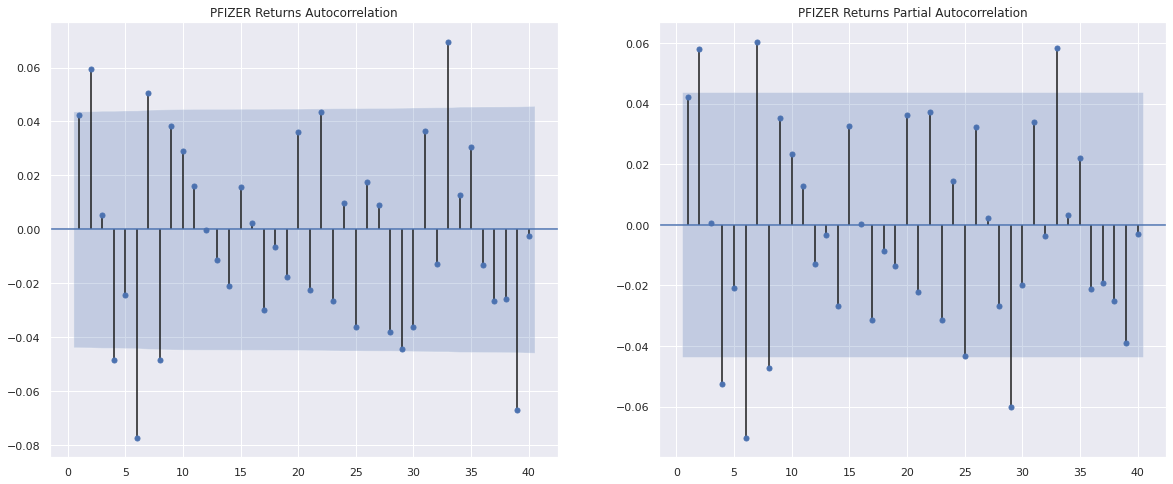

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sgt.plot_acf(df1.PFIZER_ret[1:], lags=40, zero=False, ax=ax1,title='PFIZER Returns Autocorrelation')
sgt.plot_pacf(df1.PFIZER_ret[1:],lags=40, zero=False, ax=ax2,title='PFIZER Returns Partial Autocorrelation' )
plt.show()

6th and 9th lag is significant in our analysis; we can start our analysis by taking p=6 and q=6.

Testing for **seasonality** 

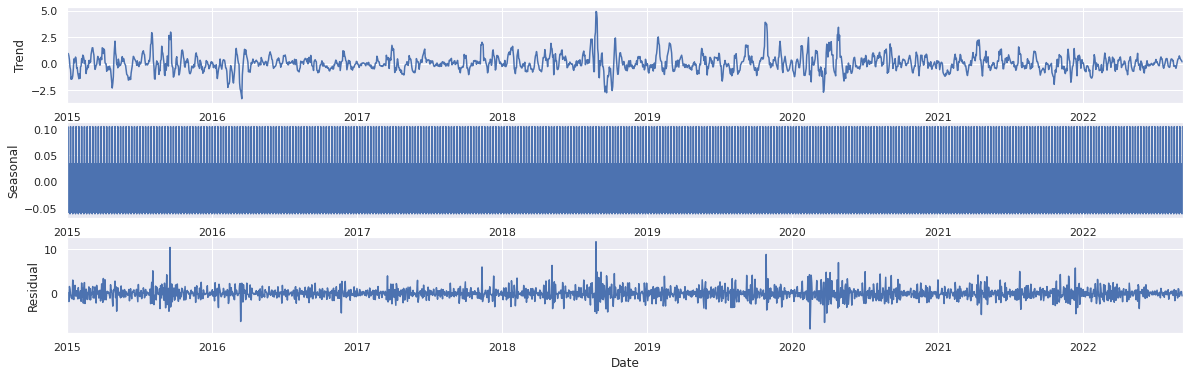

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6))
season=seasonal_decompose(df1.PFIZER_ret[1:], model='additive') 
season.trend.plot(ax=ax1)
ax1.set_ylabel("Trend")
season.seasonal.plot(ax=ax2)
ax2.set_ylabel("Seasonal")
season.resid.plot(ax=ax3)
ax3.set_ylabel("Residual")
plt.show()

Seasonal fluctuations are close to 0. Hence, we can say that Actual=Trend+Residual+Seasonal(seasonal is close to zero)

Log Likelihood Ratio Test

In [ ]:
def LLR_test(mod_1, mod_2, df):
    from scipy.stats import chi2
    l1=mod_1.llf
    l2=mod_2.llf
    p=chi2.sf(2*(l2-l1), df).round(3)
    return p

In [ ]:
model = auto_arima(
    df_train.PFIZER,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=8,
    max_q=8,
    m=1,  # frequency of series
    d=1,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

In [ ]:
arima111 = ARIMA(df_train.PFIZER, order=(1,1,1))
result_arima111=arima111.fit()
result_arima111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.PFIZER   No. Observations:                 1606
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8529.207
Method:                       css-mle   S.D. of innovations             49.004
Date:                Mon, 12 Sep 2022   AIC                          17066.414
Time:                        06:36:04   BIC                          17087.940
Sample:                    01-01-2015   HQIC                         17074.406
                         - 02-25-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.6151      1.323      1.221      0.222      -0.978       4.209
ar.L1.D.PFIZER     0.3961      0.196      2.025      0.043       0.013       0.779
ma.L1.D.PFIZER    -0.3465      0.199     -1.743      0.081      -0.736       0.043
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5246           +0.0000j            2.5246            0.0000
MA.1            2.8862           +0.0000j            2.8862            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
start_date="2019-12-05"
end_date="2022-09-09" 

In [ ]:
df1.tail()

,PFIZER,nse,PFIZER_ret,nse_ret
,,,,
Date,,,,
2022-09-06,4311.649902,17655.599609,0.799535,-0.057745
2022-09-07,4340.799805,17624.400391,0.676073,-0.176710
2022-09-08,4320.700195,17798.750000,-0.463039,0.989251
2022-09-09,4324.000000,17833.349609,0.076372,0.194393
2022-09-12,4312.549805,17964.199219,-0.264806,0.733735


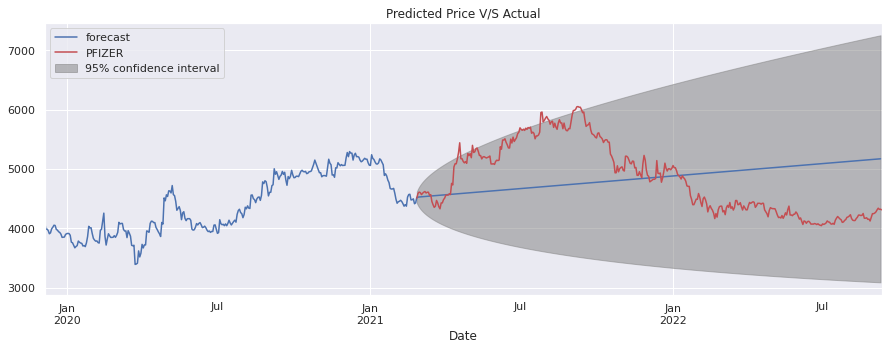

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
result_arima111.plot_predict(start=start_date, end=end_date, dynamic=False, alpha=0.05, plot_insample=False, ax=ax)
df_test.PFIZER.plot(ax=ax, color="r")
plt.title("Predicted Price V/S Actual")
plt.legend(loc=2)
plt.show()

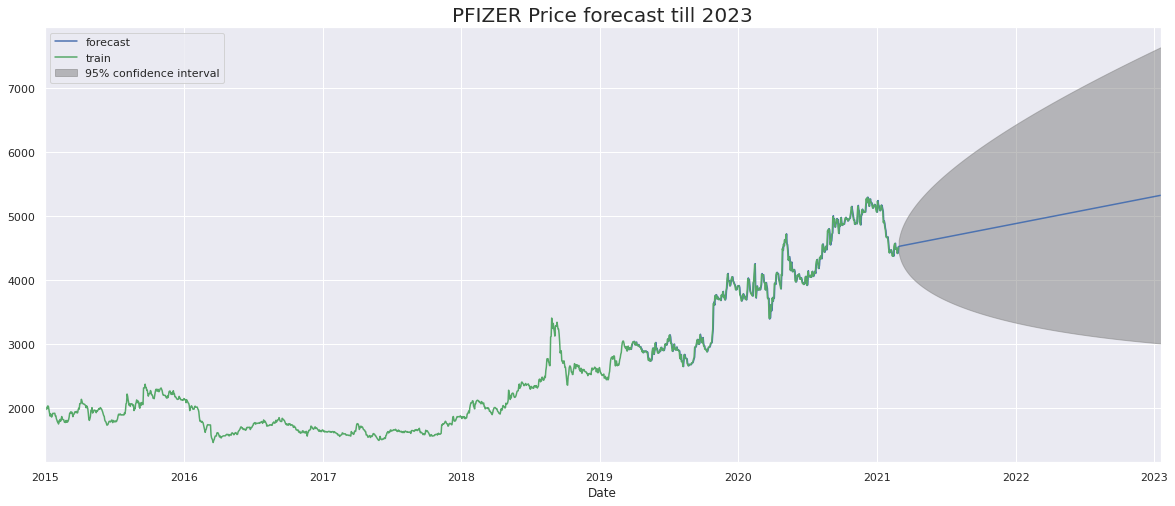

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
result_arima111.plot_predict(start=1100, end=2100, dynamic=False, alpha=0.05, plot_insample=False, ax=ax)
df_train.PFIZER.plot(ax=ax, color="g", label='train')
#df_val.icici.plot(ax=ax, color="g", label="validation")
#df_test.icici.plot(ax=ax, color="g", label="test")
#ft.plot(ax=ax,color='r', label="forecast")
plt.title("PFIZER Price forecast till 2023", size=20)
plt.legend(loc=2)
plt.show()

In [ ]:
best_model=[]
for p in range(0, 7):
    for q in range(0, 7):
        order=(p,0,q)
        model=ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=order)
        results=model.fit()
        if (p==0 & q==0):
            best=(p, q, results.aic)
        best_model.append((p, q, results.aic))
        if (results.aic < best[2]):
            best=(p, q, results.aic)
            print(best)
        else:
            continue

(1, 6, 6062.712210910682)
(3, 3, 6060.946755314701)
(3, 5, 6057.831435939103)
(4, 5, 6057.563669988762)
(4, 6, 6054.890388457526)
(5, 5, 6051.96671101392)


In [ ]:
p_list=[]
q_list=[]
aic_list=[]
for p,q,aic in best_model:
    p_list.append(p)
    q_list.append(q)
    aic_list.append(aic)
aic=pd.Series(aic_list)
md=pd.DataFrame(aic)
md["p"]=pd.Series(p_list)
md["q"]=pd.Series(q_list)
md = md.sort_values(0)
md

,0,p,q
40,6051.966711,5,5
48,6054.381442,6,6
34,6054.890388,4,6
46,6055.209025,6,4
47,6056.225466,6,5
39,6057.425445,5,4
33,6057.563670,4,5
26,6057.831436,3,5
41,6059.307584,5,6
45,6059.602700,6,3


In [ ]:
arma33 = ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=(3,0,3))
result_arma33=arma33.fit()

In [ ]:
result_arma33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PFIZER_ret   No. Observations:                 1606
Model:                     ARMA(3, 3)   Log Likelihood               -3021.473
Method:                       css-mle   S.D. of innovations              1.587
Date:                Mon, 12 Sep 2022   AIC                           6060.947
Time:                        06:40:32   BIC                           6109.380
Sample:                    01-01-2015   HQIC                          6078.928
                         - 02-25-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0482      0.043      1.114      0.265      -0.037       0.133
nse_ret              0.4257      0.035     12.138      0.000       0.357       0.494
ar.L1.PFIZER_ret     0.0734      0.128      0.573      0.567      -0.178       0.324
ar.L2.PFIZER_ret     0.3197      0.146      2.195      0.028       0.034       0.605
ar.L3.PFIZER_ret    -0.7189      0.126     -5.709      0.000      -0.966      -0.472
ma.L1.PFIZER_ret    -0.0080      0.122     -0.065      0.948      -0.248       0.232
ma.L2.PFIZER_ret    -0.2752      0.151     -1.825      0.068      -0.571       0.020
ma.L3.PFIZER_ret     0.7328      0.134      5.467      0.000       0.470       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0126           -0.0000j            1.0126           -0.5000
AR.2            0.7287           -0.9180j            1.1720           -0.1432
AR.3            0.7287           +0.9180j            1.1720            0.1432
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2            0.6878           -0.9443j            1.1682           -0.1498
MA.3            0.6878           +0.9443j            1.1682            0.1498
-----------------------------------------------------------------------------
"""

In [ ]:
arma35 = ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=(3,0,5))
result_arma35=arma35.fit()

In [ ]:
result_arma35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PFIZER_ret   No. Observations:                 1606
Model:                     ARMA(3, 5)   Log Likelihood               -3017.916
Method:                       css-mle   S.D. of innovations              1.584
Date:                Mon, 12 Sep 2022   AIC                           6057.831
Time:                        06:40:36   BIC                           6117.028
Sample:                    01-01-2015   HQIC                          6079.809
                         - 02-25-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0481      0.045      1.077      0.282      -0.039       0.136
nse_ret              0.4259      0.036     11.721      0.000       0.355       0.497
ar.L1.PFIZER_ret     0.9739      0.114      8.523      0.000       0.750       1.198
ar.L2.PFIZER_ret     0.3110      0.196      1.585      0.113      -0.073       0.696
ar.L3.PFIZER_ret    -0.7207      0.112     -6.425      0.000      -0.940      -0.501
ma.L1.PFIZER_ret    -0.9308      0.116     -8.058      0.000      -1.157      -0.704
ma.L2.PFIZER_ret    -0.2888      0.192     -1.501      0.133      -0.666       0.088
ma.L3.PFIZER_ret     0.6692      0.104      6.410      0.000       0.465       0.874
ma.L4.PFIZER_ret    -0.0693      0.035     -1.961      0.050      -0.138   -4.76e-05
ma.L5.PFIZER_ret     0.1121      0.026      4.395      0.000       0.062       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3433           -0.0000j            1.3433           -0.5000
AR.2            0.8875           -0.4953j            1.0164           -0.0810
AR.3            0.8875           +0.4953j            1.0164            0.0810
MA.1            0.8895           -0.4832j            1.0123           -0.0792
MA.2            0.8895           +0.4832j            1.0123            0.0792
MA.3           -1.2275           -0.0000j            1.2275           -0.5000
MA.4            0.0332           -2.6629j            2.6631           -0.2480
MA.5            0.0332           +2.6629j            2.6631            0.2480
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(result_arma33, result_arma35,1)

0.008

ARMA(3,3) is better with respect to Log-Likelihood Function

In [ ]:
arma45 = ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=(4,0,5))
result_arma45=arma45.fit()

In [ ]:
result_arma45.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PFIZER_ret   No. Observations:                 1606
Model:                     ARMA(4, 5)   Log Likelihood               -3016.782
Method:                       css-mle   S.D. of innovations              1.583
Date:                Mon, 12 Sep 2022   AIC                           6057.564
Time:                        06:40:42   BIC                           6122.142
Sample:                    01-01-2015   HQIC                          6081.539
                         - 02-25-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0482      0.040      1.190      0.234      -0.031       0.127
nse_ret              0.4197      0.036     11.593      0.000       0.349       0.491
ar.L1.PFIZER_ret    -0.7127      0.173     -4.125      0.000      -1.051      -0.374
ar.L2.PFIZER_ret     0.7054      0.230      3.068      0.002       0.255       1.156
ar.L3.PFIZER_ret    -0.0141      0.213     -0.066      0.947      -0.432       0.403
ar.L4.PFIZER_ret    -0.5789      0.159     -3.650      0.000      -0.890      -0.268
ma.L1.PFIZER_ret     0.7648      0.174      4.403      0.000       0.424       1.105
ma.L2.PFIZER_ret    -0.6111      0.247     -2.478      0.013      -1.094      -0.128
ma.L3.PFIZER_ret     0.0457      0.216      0.211      0.833      -0.378       0.469
ma.L4.PFIZER_ret     0.4965      0.178      2.791      0.005       0.148       0.845
ma.L5.PFIZER_ret    -0.0580      0.031     -1.846      0.065      -0.120       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9956           -0.2342j            1.0227           -0.4632
AR.2           -0.9956           +0.2342j            1.0227            0.4632
AR.3            0.9834           -0.8273j            1.2851           -0.1113
AR.4            0.9834           +0.8273j            1.2851            0.1113
MA.1           -0.9944           -0.2200j            1.0184           -0.4653
MA.2           -0.9944           +0.2200j            1.0184            0.4653
MA.3            1.0084           -0.9650j            1.3957           -0.1215
MA.4            1.0084           +0.9650j            1.3957            0.1215
MA.5            8.5283           -0.0000j            8.5283           -0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(result_arma45, result_arma35, 1)

1.0

ARMA(3,3) is better with respect to Log-Likelihood Function

In [ ]:
arma46 = ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=(4,0,6))
result_arma46=arma46.fit()

In [ ]:
result_arma46.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PFIZER_ret   No. Observations:                 1606
Model:                     ARMA(4, 6)   Log Likelihood               -3014.445
Method:                       css-mle   S.D. of innovations              1.581
Date:                Mon, 12 Sep 2022   AIC                           6054.890
Time:                        06:40:54   BIC                           6124.850
Sample:                    01-01-2015   HQIC                          6080.864
                         - 02-25-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0483      0.044      1.098      0.272      -0.038       0.134
nse_ret              0.4199      0.036     11.542      0.000       0.349       0.491
ar.L1.PFIZER_ret    -0.1730      0.034     -5.129      0.000      -0.239      -0.107
ar.L2.PFIZER_ret     1.3410      0.030     44.389      0.000       1.282       1.400
ar.L3.PFIZER_ret    -0.2128      0.032     -6.700      0.000      -0.275      -0.151
ar.L4.PFIZER_ret    -0.9168      0.034    -26.854      0.000      -0.984      -0.850
ma.L1.PFIZER_ret     0.2187      0.041      5.277      0.000       0.137       0.300
ma.L2.PFIZER_ret    -1.2733      0.039    -32.899      0.000      -1.349      -1.197
ma.L3.PFIZER_ret     0.1673      0.053      3.175      0.001       0.064       0.271
ma.L4.PFIZER_ret     0.7988      0.054     14.865      0.000       0.694       0.904
ma.L5.PFIZER_ret     0.0601      0.027      2.258      0.024       0.008       0.112
ma.L6.PFIZER_ret     0.0988      0.027      3.690      0.000       0.046       0.151
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8861           -0.4951j            1.0150           -0.0811
AR.2            0.8861           +0.4951j            1.0150            0.0811
AR.3           -1.0021           -0.2334j            1.0289           -0.4636
AR.4           -1.0021           +0.2334j            1.0289            0.4636
MA.1            0.8884           -0.4841j            1.0117           -0.0794
MA.2            0.8884           +0.4841j            1.0117            0.0794
MA.3           -0.9980           -0.2169j            1.0213           -0.4659
MA.4           -0.9980           +0.2169j            1.0213            0.4659
MA.5           -0.1943           -3.0728j            3.0789           -0.2600
MA.6           -0.1943           +3.0728j            3.0789            0.2600
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(result_arma33, result_arma46, 4)

0.007

In [ ]:
arma55 = ARIMA(df_train.PFIZER_ret[1:],exog=df_train[["nse_ret"]][1:], order=(5,0,5))
result_arma55=arma55.fit()

In [ ]:
result_arma55.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             PFIZER_ret   No. Observations:                 1606
Model:                     ARMA(5, 5)   Log Likelihood               -3012.983
Method:                       css-mle   S.D. of innovations              1.574
Date:                Mon, 12 Sep 2022   AIC                           6051.967
Time:                        06:43:27   BIC                           6121.926
Sample:                    01-01-2015   HQIC                          6077.940
                         - 02-25-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0478      0.040      1.189      0.234      -0.031       0.127
nse_ret              0.4221      0.035     12.138      0.000       0.354       0.490
ar.L1.PFIZER_ret     0.8964      0.006    138.989      0.000       0.884       0.909
ar.L2.PFIZER_ret    -0.4798      0.010    -47.239      0.000      -0.500      -0.460
ar.L3.PFIZER_ret    -0.4495      0.012    -36.262      0.000      -0.474      -0.425
ar.L4.PFIZER_ret     0.8496      0.013     67.058      0.000       0.825       0.874
ar.L5.PFIZER_ret    -0.9725      0.008   -125.434      0.000      -0.988      -0.957
ma.L1.PFIZER_ret    -0.8735      0.004   -223.452      0.000      -0.881      -0.866
ma.L2.PFIZER_ret     0.4654      0.008     60.961      0.000       0.450       0.480
ma.L3.PFIZER_ret     0.4654      0.007     69.125      0.000       0.452       0.479
ma.L4.PFIZER_ret    -0.8737      0.007   -132.057      0.000      -0.887      -0.861
ma.L5.PFIZER_ret     0.9998      0.006    154.723      0.000       0.987       1.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0131           -0.0000j            1.0131           -0.5000
AR.2            0.1073           -1.0016j            1.0074           -0.2330
AR.3            0.1073           +1.0016j            1.0074            0.2330
AR.4            0.8361           -0.5487j            1.0001           -0.0924
AR.5            0.8361           +0.5487j            1.0001            0.0924
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2            0.8354           -0.5498j            1.0001           -0.0926
MA.3            0.8354           +0.5498j            1.0001            0.0926
MA.4            0.1015           -0.9948j            1.0000           -0.2338
MA.5            0.1015           +0.9948j            1.0000            0.2338
-----------------------------------------------------------------------------
"""

In [ ]:
LLR_test(result_arma33, result_arma55, 4)

0.002

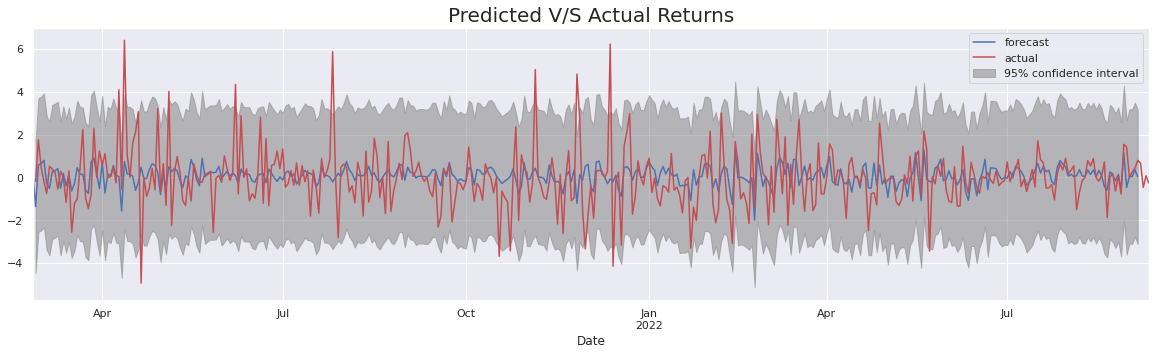

In [ ]:
fig, ax= plt.subplots(1,1,figsize=(20,5))
result_arma33.plot_predict(start=start_date, end = end_date, ax=ax, alpha=0.05, dynamic=True, plot_insample=False,
                               exog=df_test[["nse_ret"]][start_date:end_date])
df_test.PFIZER_ret.plot(color='r', ax=ax, label='actual')
plt.title("Predicted V/S Actual Returns", size=20)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
start_date="2021-02-25"
end_date="2022-09-11"

In [ ]:
y_hat=result_arma33.predict(start=start_date, 
                                 end = end_date, 
                                 dynamic=True,
                                 exog=df_test[["nse_ret"]][start_date:end_date]
)
r2_score(df_test.PFIZER_ret.values,y_hat.values)

**Checking Residuals for Overfitting Case**

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 402 entries, 2021-02-26 to 2022-09-12
Freq: B
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (PFIZER, )      402 non-null    float64
 1   (nse, )         402 non-null    float64
 2   (PFIZER_ret, )  402 non-null    float64
 3   (nse_ret, )     402 non-null    float64
dtypes: float64(4)
memory usage: 31.9 KB


In [ ]:
forecast=result_arma33.predict(start=1000, 
                               end=2100,
                               dynamic=True,
                               exog=df1[["nse_ret"]][1:1000]) 
forecast

2018-11-01   -0.127635
2018-11-02    0.765560
2018-11-05    0.115443
2018-11-06    0.197463
2018-11-07    0.385834
                ...   
2023-01-13   -0.117853
2023-01-16    0.017422
2023-01-17   -0.716239
2023-01-18    0.441231
2023-01-19    0.213151
Freq: B, Length: 1101, dtype: float64

In [ ]:
mse=((forecast[start_date:end_date][1:]-df_test.PFIZER_ret/100+1)**2).mean()
mse

1.2930958164355562

In [ ]:
forecast=forecast/100+1
forecast

2018-11-01    0.998724
2018-11-02    1.007656
2018-11-05    1.001154
2018-11-06    1.001975
2018-11-07    1.003858
                ...   
2023-01-13    0.998821
2023-01-16    1.000174
2023-01-17    0.992838
2023-01-18    1.004412
2023-01-19    1.002132
Freq: B, Length: 1101, dtype: float64

In [ ]:
test=forecast[start_date:][1:]
price=df_train.PFIZER[-1:]
def forecast_price(price, test):
    p=[]
    for i in test:
        price=price*i
        price=price.round(3)
        p.append(price)
    test_price=pd.DataFrame(p)
    test_price.columns=['forecast']
    test_price['index']=test.index
    test=test_price.set_index("index")
    return test
ft=forecast_price(price, test)

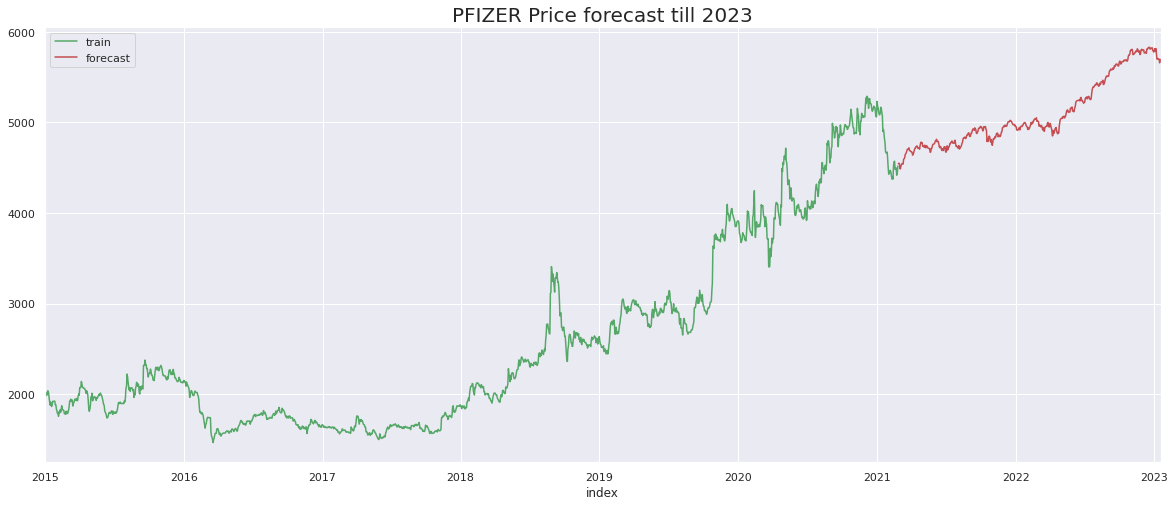

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
#result_arima111.plot_predict(start=1100, end=2100, dynamic=False, alpha=0.05, plot_insample=False, ax=ax)
df_train.PFIZER.plot(ax=ax, color="g", label='train')
#df_val.icici.plot(ax=ax, color="g", label="validation")
#df_test.icici.plot(ax=ax, color="g", label="test")
ft.plot(ax=ax,color='r', label="forecast")
plt.title("PFIZER Price forecast till 2023", size=20)
plt.legend(loc=2)
plt.show()

**Forecasting Volatality**

In [ ]:
model1 = arch_model(df1.PFIZER_ret[1:],
                    mean="constant",
                    vol="GARCH",
                    p=1,
                    q=1,
                    dist="Normal")
results1 = model1.fit(last_obs= start_date, update_freq=10)
results1.summary()

Iteration:     10,   Func. Count:     64,   Neg. LLF: 3011.9812411956273
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3011.980829139684
            Iterations: 14
            Function evaluations: 83
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             PFIZER_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3011.98
Distribution:                  Normal   AIC:                           6031.96
Method:            Maximum Likelihood   BIC:                           6053.49
                                        No. Observations:                 1605
Date:                Mon, Sep 12 2022   Df Residuals:                     1604
Time:                        06:55:08   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0360  3.624e-02      0.994      0.320 [-3.503e-02,  0.107]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1282  6.187e-02      2.073  3.820e-02 [6.976e-03,  0.250]
alpha[1]       0.0913  3.578e-02      2.553  1.067e-02 [2.123e-02,  0.161]
beta[1]        0.8709  3.917e-02     22.234 1.622e-109   [  0.794,  0.948]
==========================================================================

Covariance estimator: robust
"""

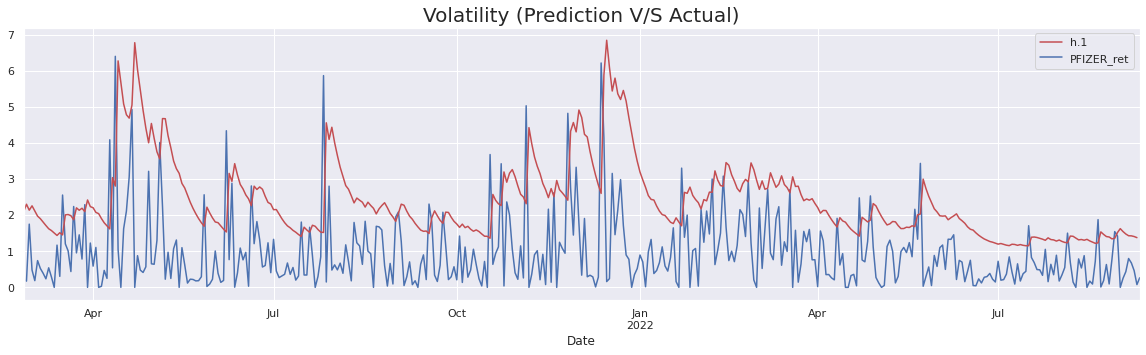

In [ ]:
pred_garch = results1.forecast(horizon=1, align="target")
pred_garch.residual_variance[start_date:end_date].plot(figsize=(20,5), zorder=2, color='r')
df_test.PFIZER_ret.abs().plot(zorder=1)
plt.title("Volatility (Prediction V/S Actual)", size=20)
plt.legend()
plt.show()

**Comparison**

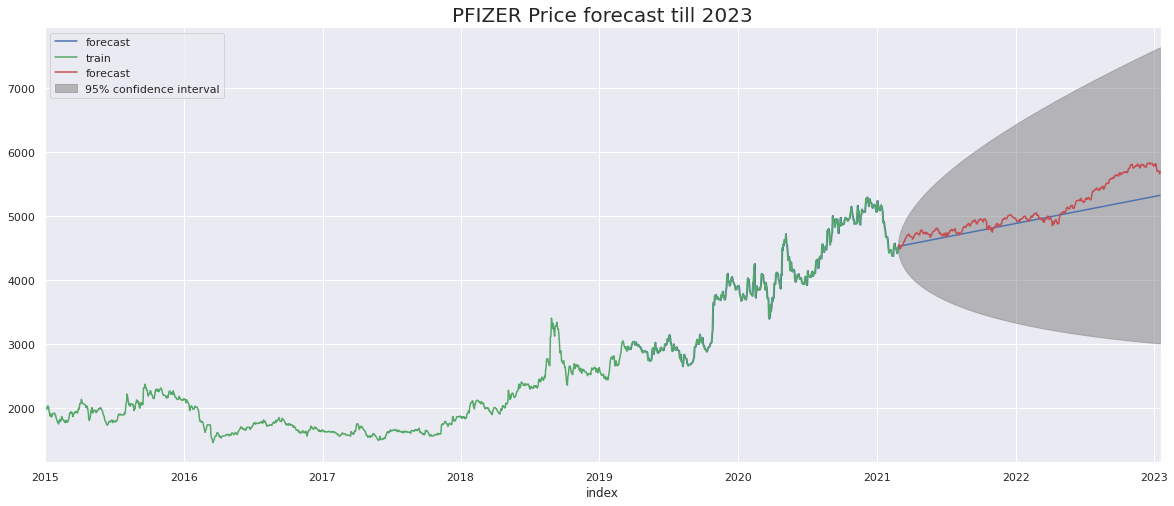

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
result_arima111.plot_predict(start=1100, end=2100, dynamic=False, alpha=0.05, plot_insample=False, ax=ax)
df_train.PFIZER.plot(ax=ax, color="g", label='train')
#df_val.icici.plot(ax=ax, color="g", label="validation")
#df_test.icici.plot(ax=ax, color="g", label="test")
ft.plot(ax=ax,color='r', label="forecast")
plt.title("PFIZER Price forecast till 2023", size=20)
plt.legend(loc=2)
plt.show()


**Real Market Scenario**

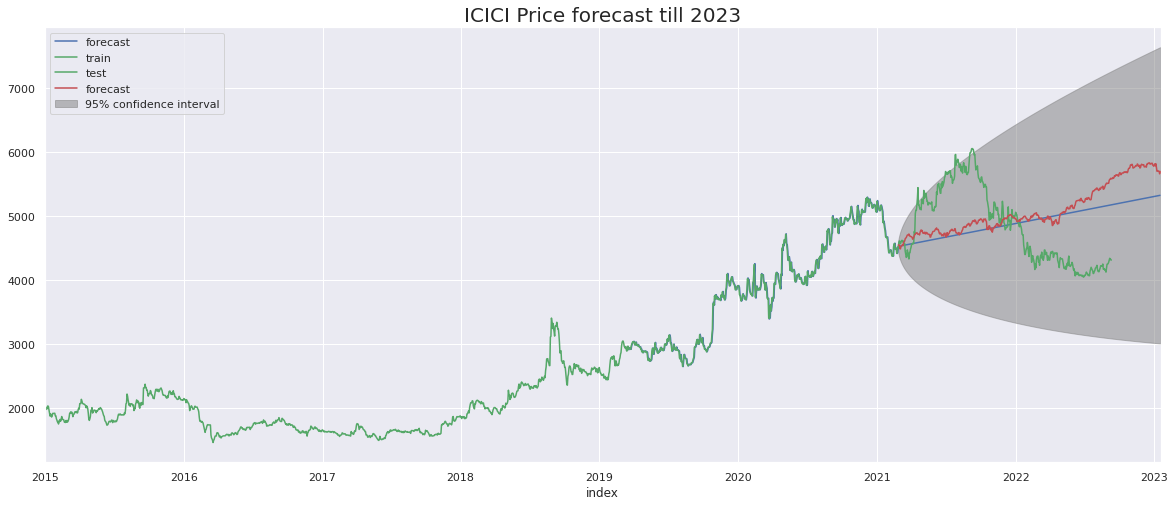

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
result_arima111.plot_predict(start=1100, end=2100, dynamic=False, alpha=0.05, plot_insample=False, ax=ax)
df_train.PFIZER.plot(ax=ax, color="g", label='train')
#df_val.icici.plot(ax=ax, color="g", label="validation")
df_test.PFIZER.plot(ax=ax, color="g", label="test")
ft.plot(ax=ax,color='r', label="forecast")
plt.title("ICICI Price forecast till 2023", size=20)
plt.legend(loc=2)
plt.show()